In [1]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import pandas as pd
import numpy as np

In [2]:
prom_file_path = "prom_pure_label.parquet"

In [3]:
prom_df = pd.read_parquet(prom_file_path)

In [6]:
prom_df

,timestamp,node,node_load15,node_load5,node_load1,node_memory_Active_bytes,node_filesystem_device_error-sum,node_netstat_Icmp_InErrors,node_netstat_Tcp_InErrs,node_netstat_Udp_InErrors,nvidia_gpu_power_usage_milliwatts-max,nvidia_gpu_temperature_celsius-max,isAnomaly
0,2022-08-01 23:00:30,r12n20,3.25,2.43,4.40,4.585050e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
1,2022-08-01 23:01:00,r12n20,3.21,2.41,3.49,4.195340e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
2,2022-08-01 23:01:30,r12n20,3.14,2.27,2.51,4.248640e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
3,2022-08-01 23:02:00,r12n20,3.07,2.15,1.91,4.248610e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
4,2022-08-01 23:02:30,r12n20,3.01,2.05,1.63,4.266120e+09,0.0,4.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123565292,2022-09-30 11:20:00,r35n5,6.33,2.92,1.16,1.612260e+10,0.0,97.0,0.0,0.0,156186.0,57.0,0
123565293,2022-09-30 11:20:30,r35n5,6.16,2.73,1.10,1.610200e+10,0.0,97.0,0.0,0.0,160405.0,55.0,0
123565294,2022-09-30 11:21:00,r35n5,5.99,2.55,0.99,1.612250e+10,0.0,97.0,0.0,0.0,165284.0,58.0,0
123565295,2022-09-30 11:21:30,r35n5,5.83,2.40,1.00,1.612330e+10,0.0,97.0,0.0,0.0,164491.0,60.0,0


In [4]:
prom_df.fillna(0, inplace=True)
kmeans = KMeans(n_clusters=2)
feature_cols = [col for col in prom_df.columns if col not in ['node', 'timestamp', 'isAnomaly','node_netstat_Udp_InErrors','node_netstat_Tcp_InErrs','node_netstat_Icmp_InErrors','node_filesystem_device_error-sum','jobID']]
kmeans.fit(prom_df[feature_cols])

pred = kmeans.predict(prom_df[feature_cols])

distances = kmeans.transform(prom_df[feature_cols])

dist_to_center = [distances[i, pred[i]] for i in range(len(pred))]

mean_dist = np.mean(dist_to_center)
pred_labels = [1 if dist > mean_dist else 0 for dist in dist_to_center]

/home/wenjun/miniconda3/envs/python_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.75      0.85 120006718
           1       0.06      0.55      0.11   3558579

    accuracy                           0.75 123565297
   macro avg       0.52      0.65      0.48 123565297
weighted avg       0.96      0.75      0.83 123565297

Confusion matrix:
 [[90219354 29787364]
 [ 1586546  1972033]]
ROC AUC Score: 0.652974457341788


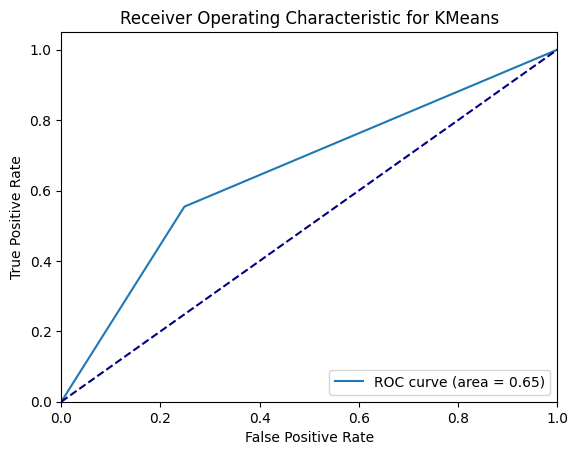

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np


print(classification_report(prom_df['isAnomaly'], pred_labels))

conf_mat = confusion_matrix(prom_df['isAnomaly'], pred_labels)
print('Confusion matrix:\n', conf_mat)

roc_auc = roc_auc_score(prom_df['isAnomaly'], pred_labels)
print('ROC AUC Score:', roc_auc)

fpr, tpr, _ = roc_curve(prom_df['isAnomaly'], pred_labels)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for KMeans')
plt.legend(loc="lower right")

plt.savefig('kmeans_roc_curve.pdf', format='pdf')

plt.show()
